# __PRÁCTICA 2 · PARTE 1: ANÁLISIS DE SENTIMIENTO__

__GRUPO 7__

Beatriz Herguedas Pinedo

Pablo Hernández Aguado

#### Bibliotecas y funciones importadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn import tree
from sklearn.metrics import recall_score

import graphviz as gvz
from IPython.display import Image, display

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

## 1. Configuración de la partición entrenamiento-test.

__*Configurar una partición train-test usando el 75% de los datos para entrenamiento y el 25% restante para test.*__

In [2]:
## Lectura del fichero de entrada.
with open('yelp_labelled.txt') as f:
    flines = f.read().splitlines()
    
messages = [ line.split('\t')[0] for line in flines]
valorations = [ int( line.split('\t')[1] ) for line in flines]

print(messages[0:10])
print(valorations[0:10])

['Wow... Loved this place.', 'Crust is not good.', 'Not tasty and the texture was just nasty.', 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.', 'The selection on the menu was great and so were the prices.', 'Now I am getting angry and I want my damn pho.', "Honeslty it didn't taste THAT fresh.)", 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.', 'The fries were great too.', 'A great touch.']
[1, 0, 0, 1, 1, 0, 0, 0, 1, 1]


In [3]:
## Creación de la partición train-test según lo estipulado.
train_data, test_data, train_data_target, test_data_target = train_test_split(
    messages, valorations,
    stratify = valorations,
    test_size = 0.25,
    shuffle = True,
    random_state = 7)

In [4]:
## Comprobación de la partición de entrenamiento.
for i in range(5):
    print(train_data[i], '->', train_data_target[i])

print()
print('Tamaño:', len(train_data), '/', len(messages))

## Comprobación de la estratificación.
train_posval = sum(train_data_target)

print()
print('Estratificación:', 100 * train_posval / len(train_data), '%')

I was disgusted because I was pretty sure that was human hair. -> 0
I dressed up to be treated so rudely! -> 0
Once your food arrives it's meh. -> 0
There was a warm feeling with the service and I felt like their guest for a special treat. -> 1
Their frozen margaritas are WAY too sugary for my taste. -> 0

Tamaño: 750 / 1000

Estratificación: 50.0 %


In [5]:
## Comprobación de la partición de test.
for i in range(5):
    print(test_data[i], '->', test_data_target[i])

print()
print('Tamaño:', len(test_data), '/', len(messages))

## Comprobación de la estratificación.
test_posval = sum(test_data_target)

print()
print('Estratificación:', 100 * test_posval / len(test_data), '%')

Worst Thai ever. -> 0
The fries were not hot, and neither was my burger. -> 0
Service is perfect and the family atmosphere is nice to see. -> 1
The goat taco didn't skimp on the meat and wow what FLAVOR! -> 1
By far the BEST cheesecurds we have ever had! -> 1

Tamaño: 250 / 1000

Estratificación: 50.0 %


## 2. Configuración de los vectorizadores.

__*Vamos a estudiar varias representaciones de bolsa de palabaras, pero todas ellas utilizarán countVectorizer con el diccionario que se crea a partir de los términos del propio corpus y la lista de palabras vacías (stop_words) que proporciona sklearn para el inglés. Las 4 posibilidades que estudiaremos surgen de combinar los 2 siguientes parámetros:*__

- *Bolsa de palabras binaria (usando countVectorizer con el parámetro binary = True y sin usar TfidfTransformer) y bolsa de palabras con TF/IDF (usando countVectorizer con el parámetro binary = False y solbre el resultado el TfidfTransformer).*

- *Usando un rango de n-gramas de (1,1) y de (1,2) (parámetro ngram_range del countVectorizer). Es decir, haciendo que la bolsa de palabras se consideren solamente monogramas, o que se consideren monogramas y bigramas.*

In [6]:
## Vectorizador 1: Bolsa binaria de monogramas, sin transformación TF/IDF.
mono_bin_vectorizer = CountVectorizer(
    lowercase = True, # Por defecto es así.
    stop_words = 'english', # Palabras vacías del inglés.
    vocabulary = None, # No utilizamos ningún vocabulario predeterminado.
    ngram_range = (1,1), # Sólo monogramas.
    binary = True) # Sólo queremos saber si la "n-grama" aparece en el documento.   

In [7]:
## Vectorizador 2: Bolsa binaria de monogramas-bigramas, sin transformación TF/IDF.
duo_bin_vectorizer = CountVectorizer(
    lowercase = True, # Por defecto es así.
    stop_words = 'english', # Palabras vacías del inglés.
    vocabulary = None, # No utilizamos ningún vocabulario predeterminado.
    ngram_range = (1,2), # Monogramas y bigramas.
    binary = True) # Sólo queremos saber si el "n-grama" aparece en el documento.   

In [8]:
## Vectorizador 3: Bolsa no binaria de monogramas (con transformación TF/IDF)
mono_tfidf_vectorizer = CountVectorizer(
    lowercase = True, # Por defecto es así.
    stop_words = 'english', # Palabras vacías del inglés.
    vocabulary = None, # No utilizamos ningún vocabulario predeterminado.
    ngram_range = (1,1), # Sólo monogramas.
    binary = False) # Contamos apariciones del "n-grama" en el documento.

In [9]:
## Vectorizador 4: Bolsa no binaria de monogramas-bigramas (con transformación TF/IDF)
duo_tfidf_vectorizer = CountVectorizer(
    lowercase = True, # Por defecto es así.
    stop_words = 'english', # Palabras vacías del inglés.
    vocabulary = None, # No utilizamos ningún vocabulario predeterminado.
    ngram_range = (1,2), # Monogramas y bigramas.
    binary = False) # Contamos apariciones del "n-grama" en el documento.

## 3. Construcción de clasificadores.

__*Para cada una de esas 4 combinaciones entrenaremos dos clasificadores:*__

- Un clasificador Naive Bayes, eligiendo el más adecuado para cada caso.
- Un árbol de decisión buscando un valor óptimo para uno de los siguiente parámetros para que se maximice la tasa de aciertos en el conjunto de test: max_depth, min_samples_leaf o max_leaf_nodes. Tomar siempre el mismo parámetro para todos las 4 vectorizaciones.

## 3.1. Vectorización I: binaria y (1,1).

In [10]:
# Vectorizamos los datos del conjunto de entrenamiento (sin aplicar TF/IDF en este caso).
## Con fit_transform, el vectorizador aprende el vocabulario de todo el conjunto de mensajes
## y devuelve la matriz de frecuencias (binarias en este caso) de término por documento.
## Esta matriz es una matriz dispersa; tipo: crs_matrix.
mono_bin_trainvd = mono_bin_vectorizer.fit_transform(train_data)

In [11]:
## Como podemos observar, la matriz dispersa guarda únicamente aquellas "celdas" distintas de cero,
## que en este caso toman valor 1 por ser una vectorización binaria.
## A pesar de ser una configuración binaria, el tipo de la matriz es entero, no booleano.
print(mono_bin_trainvd.dtype)
print(mono_bin_trainvd[:3])

int64
  (0, 381)	1
  (0, 1034)	1
  (0, 1322)	1
  (0, 666)	1
  (0, 604)	1
  (1, 406)	1
  (1, 1388)	1
  (1, 1146)	1
  (2, 523)	1
  (2, 57)	1
  (2, 833)	1


In [12]:
## Vemos también que la bolsa de palabras está formadas por monogramas, es decir,
## cadenas sin espacios entre ellas.
mono_bin_featnames = mono_bin_vectorizer.get_feature_names()

print('Tamaño:', len(mono_bin_featnames), '\n')
print(mono_bin_featnames[:25], '\n...')
print(mono_bin_featnames[-25:])

Tamaño: 1522 

['00', '10', '100', '11', '12', '15', '1979', '20', '30', '30s', '35', '40', '4ths', '5lb', '70', '90', '99', 'absolutely', 'absolutley', 'accident', 'accommodations', 'accomodate', 'accordingly', 'accountant', 'ache'] 
...
['worker', 'workers', 'working', 'works', 'worries', 'worse', 'worst', 'worth', 'wouldn', 'wound', 'wow', 'wrap', 'wrapped', 'writing', 'wrong', 'ya', 'yama', 'yeah', 'year', 'years', 'yellow', 'yelpers', 'yum', 'yummy', 'zero']


In [13]:
# Vectorizamos los datos del conjunto de test. 
## Usamos el vocabulario ya aprendido por el vectorizador tras el análisis del conjunto de entrenamiento.
## Por tanto, basta con transformar directamente sin ajustar.
mono_bin_testvd = mono_bin_vectorizer.transform(test_data)

### 3.1.1. Vectorización I: Naive Bayes

En tanto que la vectorización genera valores binarios para los n-gramas (que representan la aparación o no de ese n-grama en el mensaje), el clasificador Naive Bayes más apropiado sería el de tipo _Bernoulli_. 

No obstante, también podemos aplicar el de tipo _Multinomial_ donde los valores binarios se traducen a las "frecuencias" 0 y 1.

#### Naive Bayes: Bernoulli

In [14]:
# Clasificador Naive Bayes de tipo Bernoulli.
## Asume una distribución Bernoulli multivariable.
mono_bin_bnbclass = BernoulliNB(
    alpha = 1.0, # Valor aditivo de smoothing, para evitar probabilidades nulas.
    binarize = 0.0, # Umbral para binarizar enteros (menores o iguales que el valor mapean a False)
    fit_prior = True, # Aprende la probabilidad de cada clase del conjunto de entrenamiento.
)

## * Por la estratificación del conjunto de entrenamiento, poner fit_prior a True generará una 
##   distribución uniforme, que se habría generado por defecto también si fit_prior fuese False.

In [15]:
# Ajustamos el clasificador con los datos de entranamiento.
mono_bin_bnbclass.fit(mono_bin_trainvd, train_data_target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [16]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
mono_bin_bnb_trainp = mono_bin_bnbclass.predict(mono_bin_trainvd)
mono_bin_bnb_testp = mono_bin_bnbclass.predict(mono_bin_testvd)

In [17]:
# Obtenemos las medias de acierto del clasificador para entrenamiento-test.
mono_bin_bnb_trainscr = np.mean(mono_bin_bnb_trainp == train_data_target)
mono_bin_bnb_testscr = np.mean(mono_bin_bnb_testp == test_data_target)

print("VECTORIZACIÓN I: BERNOULLI NB")
print("Porcentaje de aciertos en entrenamiento:", mono_bin_bnb_trainscr)
print("Porcentaje de aciertos en test:", mono_bin_bnb_testscr)

VECTORIZACIÓN I: BERNOULLI NB
Porcentaje de aciertos en entrenamiento: 0.948
Porcentaje de aciertos en test: 0.74


#### Naive Bayes: Multinomial

In [18]:
# Clasificador Naive Bayes de tipo Multinomial.
## Asume una distribución multinomial.
mono_bin_mnbclass = MultinomialNB(
    alpha = 1.0, # Valor aditivo de smoothing, para evitar probabilidades nulas.
    fit_prior = True, # Aprende la probabilidad de cada clase del conjunto de entrenamiento.
)

In [19]:
# Ajustamos el clasificador con los datos de entranamiento.
mono_bin_mnbclass.fit(mono_bin_trainvd, train_data_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
mono_bin_mnb_trainp = mono_bin_mnbclass.predict(mono_bin_trainvd)
mono_bin_mnb_testp = mono_bin_mnbclass.predict(mono_bin_testvd)

In [21]:
# Obtenemos las medias de acierto del clasificador para entrenamiento-test.
mono_bin_mnb_trainscr = np.mean(mono_bin_mnb_trainp == train_data_target)
mono_bin_mnb_testscr = np.mean(mono_bin_mnb_testp == test_data_target)

print("VECTORIZACIÓN I: MULTINOMIAL NB")
print("Porcentaje de aciertos en entrenamiento:", mono_bin_mnb_trainscr)
print("Porcentaje de aciertos en test:", mono_bin_mnb_testscr)

VECTORIZACIÓN I: MULTINOMIAL NB
Porcentaje de aciertos en entrenamiento: 0.9573333333333334
Porcentaje de aciertos en test: 0.756


**Conclusión.**

En primer lugar, los porcentajes de acierto quedan así:

|   Vect. I   | % train | % test |
|------------:|--------:|-------:|
|  Bernoulli  |   94.8  |  74.0  |
| Multinomial |   95.7  |  75.6  |

Como podemos ver, hay una escasa diferencia entre los porcentajes de acierto de los clasificadores Bernoulli y Multinomial, siendo ligeramente superior este último, tanto en entrenamiento como en test.

Ambos clasifican el conjunto de test con una precisión aceptable de en torno al 75%. No obstante, ambos tienen un alto porcentaje de acierto en entrenamiento: en torno a un 95%. La diferencia entre estos valores implica que estos clasificadores tienen un fuerte sobreaprendizaje sobre el conjunto de entrenamiento, aunque clasifican de forma aceptable el conjunto de test.

A sobreaprendizaje alto y parecido, nos quedamos con el clasificador Multinomial, que mejora ligeramente (por 1.6 puntos) en precisión en test al clasificador Bernoulli.

### 3.1.2. Vectorización I: Árbol de Decisión

Para el árbol de decisión, vamos a optimizar sobre el parámetro *max_depth*, que determina la profundidad máxima que puede alcanzar el árbol.

In [22]:
# Construimos árboles de decisión en función del parámetro max_leaf_nodes.
## Guardamos los porcentajes de acierto de entrenamiento-test en sendos vectores
## para luego ver su representación gráfica y elegir el mejor valor para el parámetro.
mono_bin_trainrc = []
mono_bin_testrc = []

mono_bin_depth = range(1,75)
for depth in mono_bin_depth:
    clfCheck = tree.DecisionTreeClassifier(
        criterion = 'gini',
        max_depth = depth,
        random_state = 7)
    
    clfCheck.fit(mono_bin_trainvd, train_data_target)
    
    y_train_prediction = clfCheck.predict(mono_bin_trainvd)
    y_test_prediction = clfCheck.predict(mono_bin_testvd)
    
    train_scr = recall_score(train_data_target, y_train_prediction, average = "micro")
    test_scr = recall_score(test_data_target, y_test_prediction, average = "micro")
    
    mono_bin_trainrc.append(train_scr)
    mono_bin_testrc.append(test_scr)

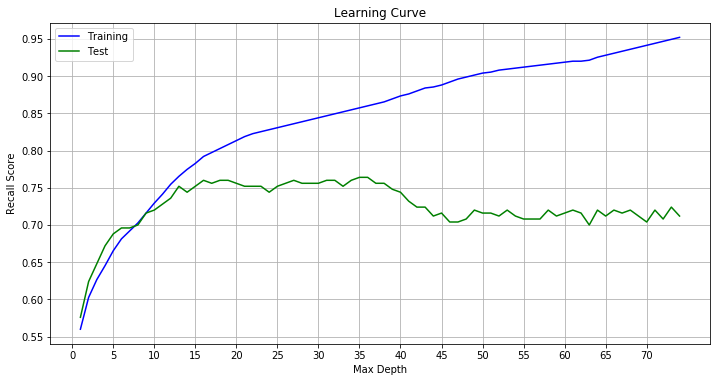

In [24]:
# Graficamos los porcentajes de acierto para cada valor del parámetro max_leaf_nodes.
## Buscamos un valor que maximice el acierto del conjunto de test, pero que no tenga
## un fuerte sobreaprendizaje sobre el conjunto de entrenamiento.
plt.plot(
    mono_bin_depth,
    mono_bin_trainrc, 
    color = 'b', 
    label = 'Training')

plt.plot(
    mono_bin_depth,
    mono_bin_testrc, 
    color = 'g', 
    label = 'Test')


plt.title('Learning Curve')
plt.xlabel('Max Depth')
plt.xticks(range(0,75,5))
plt.ylabel('Recall Score')
plt.legend( loc = 'best' )
plt.grid()
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54] # Conversión cm -> in.
plt.show()

In [25]:
# Buscamos el valor óptimo para el conjunto de test.
mono_bin_optdepth = np.argmax(mono_bin_testrc) + 1
print('Profundidad máxima óptima:', mono_bin_optdepth)
print("Porcentaje de acierto en entrenamiento:", mono_bin_trainrc[mono_bin_optdepth - 1])
print("Porcentaje de acierto en test:", mono_bin_testrc[mono_bin_optdepth - 1])

Profundidad máxima óptima: 35
Porcentaje de acierto en entrenamiento: 0.8573333333333333
Porcentaje de acierto en test: 0.764


Como podemos observar en la gráfica, tanto el acierto de entrenamiento como el de test aumentan intensamente hasta, aproximadamente, la profundidad 15.

A partir de ese punto, el acierto de entrenamiento continua aumentando de forma casi lineal; mientras que el acierto de test se mantiene más o menos estable en el intervalo (0.74, 0.76) hasta la profundidad 35. Además, alcanza el máximo en esta profundidad (y en 36 también).

A continuación, el acierto de test desciende y queda estabilizado en el intervalo (0.70, 0.73) a medida que aumenta la profundidad y el árbol sobreaprende del conjunto de entrenamiento.

En conclusión, la diferencia en acierto en test entre el valor óptimo a profundidad 35 y el valor a profundidad 16 (a ojo) no es muy grande. Así, es posible que para el valor óptimo obtengamos un árbol con más sobreaprendizaje, y no necesariamente más preciso que para profundidad 16.

No obstante, como se pide, construimos el árbol de profundidad 35; dejando que estas observaciones salgan a la luz más adelante cuando analicemos los árboles en conjunto.

#### max_depth = 35

In [26]:
# Árbol de decisión con max_leaf_nodes = 30.
mono_bin_opttree = tree.DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = mono_bin_optdepth,
    random_state = 7
    )

In [27]:
## Ajustamos el árbol al conjunto de datos.
mono_bin_opttree.fit(mono_bin_trainvd, train_data_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=35, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [28]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
mono_bin_opttree_trainp = mono_bin_opttree.predict(mono_bin_trainvd)
mono_bin_opttree_testp = mono_bin_opttree.predict(mono_bin_testvd)

In [29]:
## Calculamos los porcentajes de acierto.
mono_bin_opttree_trainscr = np.mean(mono_bin_opttree_trainp == train_data_target)
mono_bin_opttree_testscr = np.mean(mono_bin_opttree_testp == test_data_target)

print("VECTORIZACIÓN I: ÁRBOL DE DECISIÓN ÓPTIMO")
print('Profundidad máxima:', mono_bin_optdepth)
print("Porcentaje de aciertos en entrenamiento:", mono_bin_opttree_trainscr)
print("Porcentaje de aciertos en test:", mono_bin_opttree_testscr)

VECTORIZACIÓN I: ÁRBOL DE DECISIÓN ÓPTIMO
Profundidad máxima: 35
Porcentaje de aciertos en entrenamiento: 0.8573333333333333
Porcentaje de aciertos en test: 0.764


## 3.2. Vectorización II: binaria y (1,2).

En este caso, el procedimiento es análogo al de la vectorización I, pues las únicas diferencias que encontraremos serán las generadas por la presencia de bigramas.

Por tanto, repetimos lo anterior, creando 2 clasificadores Naive Bayes: Bernoulli y Multinomial; y hallando el valor óptimo del parámetro del árbol de decisión.

In [30]:
# Vectorizamos los datos del conjunto de entrenamiento (sin aplicar TF/IDF en este caso).
duo_bin_trainvd = duo_bin_vectorizer.fit_transform(train_data)

In [31]:
## Como podemos observar, los términos de esta bolsa de palabras también contienen bigramas,
## es decir, términos formados por dos palabras consecutivas. Esto aumenta considerablemente
## el tamaño de la bolsa de palabras o n-gramas.
duo_bin_featnames = duo_bin_vectorizer.get_feature_names()

print('Tamaño:', len(duo_bin_featnames))
print('Ratio:', len(duo_bin_featnames) / len(mono_bin_featnames), '\n')
print(duo_bin_featnames[:25], '\n...')
print(duo_bin_featnames[-25:])

Tamaño: 4377
Ratio: 2.875821287779238 

['00', '10', '10 minutes', '10 times', '100', '100 recommended', '100 times', '11', '11 99', '12', '12 ridiculous', '15', '15 minutes', '1979', '1979 time', '20', '20 just', '20 minutes', '30', '30 min', '30 minutes', '30s', '35', '35 big', '35 minutes'] 
...
['wrong', 'wrong burned', 'wrong donut', 'ya', 'yama', 'yama good', 'yeah', 'yeah sucks', 'year', 'year ago', 'years', 'years ago', 'years living', 'yellow', 'yellow saffron', 'yelpers', 'yelpers husband', 'yum', 'yum sauce', 'yum yum', 'yummy', 'yummy try', 'yummy tummy', 'zero', 'zero stars']


In [32]:
# Vectorizamos los datos del conjunto test.
duo_bin_testvd = duo_bin_vectorizer.transform(test_data)

### 3.2.1. Vectorización II: Naive Bayes

#### Naive Bayes: Bernoulli

In [33]:
# Clasificador Naive Bayes de tipo Bernoulli.
duo_bin_bnbclass = BernoulliNB(
    alpha = 1.0, # Valor aditivo de smoothing, para evitar probabilidades nulas.
    binarize = 0.0, # Umbral para binarizar enteros (menores o iguales que el valor mapean a False)
    fit_prior = True, # Aprende la probabilidad de cada clase (dist. uniforme) del conjunto de entrenamiento.
)

In [34]:
# Ajustamos el clasificador con los datos de entrenamiento.
duo_bin_bnbclass.fit(duo_bin_trainvd, train_data_target)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [35]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
duo_bin_bnb_trainp = duo_bin_bnbclass.predict(duo_bin_trainvd)
duo_bin_bnb_testp = duo_bin_bnbclass.predict(duo_bin_testvd)

In [36]:
# Obtenemos las medias de acierto del clasificador para entrenamiento-test.
duo_bin_bnb_trainscr = np.mean(duo_bin_bnb_trainp == train_data_target)
duo_bin_bnb_testscr = np.mean(duo_bin_bnb_testp == test_data_target)

print("VECTORIZACIÓN II: BERNOULLI NB")
print("Porcentaje de aciertos en entrenamiento:", duo_bin_bnb_trainscr)
print("Porcentaje de aciertos en test:", duo_bin_bnb_testscr)

VECTORIZACIÓN II: BERNOULLI NB
Porcentaje de aciertos en entrenamiento: 0.9786666666666667
Porcentaje de aciertos en test: 0.74


#### Naive Bayes: Multinomial

In [37]:
# Clasificador Naive Bayes de tipo Multinomial.
duo_bin_mnbclass = MultinomialNB(
    alpha = 1.0, # Valor aditivo de smoothing, para evitar probabilidades nulas.
    fit_prior = True, # Aprende la probabilidad de cada clase del conjunto de entrenamiento.
)

In [38]:
# Ajustamos el clasificador con los datos de entranamiento.
duo_bin_mnbclass.fit(duo_bin_trainvd, train_data_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
duo_bin_mnb_trainp = duo_bin_mnbclass.predict(duo_bin_trainvd)
duo_bin_mnb_testp = duo_bin_mnbclass.predict(duo_bin_testvd)

In [40]:
# Obtenemos las medias de acierto del clasificador para entrenamiento-test.
duo_bin_mnb_trainscr = np.mean(duo_bin_mnb_trainp == train_data_target)
duo_bin_mnb_testscr = np.mean(duo_bin_mnb_testp == test_data_target)

print("VECTORIZACIÓN II: MULTINOMIAL NB")
print("Porcentaje de aciertos en entrenamiento:", duo_bin_mnb_trainscr)
print("Porcentaje de aciertos en test:", duo_bin_mnb_testscr)

VECTORIZACIÓN II: MULTINOMIAL NB
Porcentaje de aciertos en entrenamiento: 0.98
Porcentaje de aciertos en test: 0.76


**Conclusión.**

En primer lugar, los porcentajes de acierto quedan así:

|   Vect. II  | % train | % test |
|------------:|--------:|-------:|
|  Bernoulli  |   97.9  |  74.0  |
| Multinomial |   98.0  |  76.0  |

Claramente, ambos presentan un porcentaje de acierto en el conjunto de entrenamiento prácticamente equivalente: de un 98 %. No es así en el acierto del conjunto de test, donde el clasificador Multinomial mejora al Bernoulii por dos puntos porcentuales: 76 % frente a 74 %.

Como ocurría en la Vectorización I, ambos presentan un alto porcentaje de acierto en entrenamiento, relacionado con un alto sobreaprendizaje.

Con porcentajes de acierto en entrenamiento equivalentes, nos quedamos con el que presenta mejor acierto en test: el Multinomial.

### 3.2.2. Vectorización II: Árbol de Decisión

In [41]:
# Construimos árboles de decisión en función del parámetro max_leaf_nodes.
## Guardamos los porcentajes de acierto de entrenamiento-test en sendos vectores
## para luego ver su representación gráfica y elegir el mejor valor para el parámetro.
duo_bin_trainrc = []
duo_bin_testrc = []

duo_bin_depth = range(1,75)
for depth in duo_bin_depth:
    clfCheck = tree.DecisionTreeClassifier(
        criterion = 'gini',
        max_depth = depth,
        random_state = 7)
    
    clfCheck.fit(duo_bin_trainvd, train_data_target)
    
    y_train_prediction = clfCheck.predict(duo_bin_trainvd)
    y_test_prediction = clfCheck.predict(duo_bin_testvd)
    
    train_scr = recall_score(train_data_target, y_train_prediction, average = "micro")
    test_scr = recall_score(test_data_target, y_test_prediction, average = "micro")
    
    duo_bin_trainrc.append(train_scr)
    duo_bin_testrc.append(test_scr)

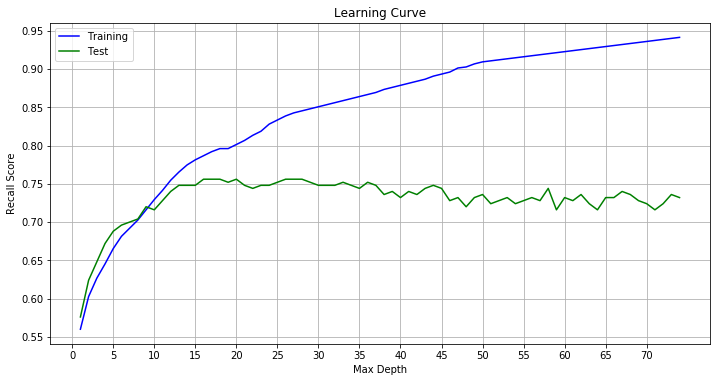

In [42]:
# Graficamos los porcentajes de acierto para cada valor del parámetro max_leaf_nodes.
## Buscamos un valor que maximice el acierto del conjunto de test, pero que no tenga
## un fuerte sobreaprendizaje sobre el conjunto de entrenamiento.
plt.plot(
    duo_bin_depth,
    duo_bin_trainrc, 
    color = 'b', 
    label = 'Training')

plt.plot(
    duo_bin_depth,
    duo_bin_testrc, 
    color = 'g', 
    label = 'Test')


plt.title('Learning Curve')
plt.xlabel('Max Depth')
plt.xticks(range(0,75,5))
plt.ylabel('Recall Score')
plt.legend( loc = 'best' )
plt.grid()
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54]
plt.show()

In [43]:
# Buscamos el valor óptimo para el conjunto de test.
duo_bin_optdepth = np.argmax(duo_bin_testrc) + 1
print('Profundidad máxima óptima:', duo_bin_optdepth)
print("Porcentaje de acierto en entrenamiento:", duo_bin_trainrc[duo_bin_optdepth - 1])
print("Porcentaje de acierto en test:", duo_bin_testrc[duo_bin_optdepth - 1])

Profundidad máxima óptima: 16
Porcentaje de acierto en entrenamiento: 0.7866666666666666
Porcentaje de acierto en test: 0.756


Como podemos observar en la gráfica, tanto el acierto de entrenamiento como el de test vuelven a crecer rápidamente hasta profundidad 15.

A partir de ese punto, el acierto de entrenamiento continua aumentando, aminorando su crecimiento; mientras que el acierto de test se mantiene, como en la vectorización anterior, más o menos estable en el intervalo (0.74, 0.76) hasta la profundidad 35. También alcanza el máximo porcentaje de acierto en este intervalo; no obstante, esta vez se da para el valor 16.

A continuación, el acierto de test desciende, quedando por debajo de un 0.75 en profundidades mayores. Por su parte, acierto en entrenamiento sigue creciendo, marcando un mayor sobreaprendizaje a mayor profundidad.

En este caso, el valor óptimo para el acierto en test ha sido de una profundidad más pequeña: 16. Por tanto, obtendremos un árbol con menor sobreaprendizaje.

#### max_depth = 16

In [44]:
# Árbol de decisión con max_leaf_nodes = 40.
duo_bin_opttree = tree.DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = duo_bin_optdepth,
    random_state = 7
    )

In [45]:
## Ajustamos el árbol al conjunto de datos.
duo_bin_opttree.fit(duo_bin_trainvd, train_data_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [46]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
duo_bin_opttree_trainp = duo_bin_opttree.predict(duo_bin_trainvd)
duo_bin_opttree_testp = duo_bin_opttree.predict(duo_bin_testvd)

In [47]:
## Calculamos los porcentajes de acierto.
duo_bin_opttree_trainscr = np.mean(duo_bin_opttree_trainp == train_data_target)
duo_bin_opttree_testscr = np.mean(duo_bin_opttree_testp == test_data_target)

print("VECTORIZACIÓN II: ÁRBOL DE DECISIÓN")
print("Porcentaje de aciertos en entrenamiento:", duo_bin_opttree_trainscr)
print("Porcentaje de aciertos en test:", duo_bin_opttree_testscr)

VECTORIZACIÓN II: ÁRBOL DE DECISIÓN
Porcentaje de aciertos en entrenamiento: 0.7866666666666666
Porcentaje de aciertos en test: 0.756


## 3.3. Vectorización III: no binaria y (1,1).

In [48]:
# Vectorizamos los datos del conjunto de entrenamiento.
mono_tfidf_trainvd = mono_tfidf_vectorizer.fit_transform(train_data)

In [49]:
# Obtenemos un transformador TF-IDF.
mono_tfidfer = TfidfTransformer()

In [50]:
# Recalculamos la matriz utilizando el transformador.
mono_tfidf_trainpp = mono_tfidfer.fit_transform(mono_tfidf_trainvd)

In [51]:
## Nos quedan los datos de la bolsa de palabras transformados por TF-IDF.
## Nos quedan datos tipo "float" en forma de matriz dispersa.
print(mono_tfidf_trainpp.dtype)
print(mono_tfidf_trainpp[:3])

float64
  (0, 1322)	0.4336901176450994
  (0, 1034)	0.34540965209314645
  (0, 666)	0.47053995358448725
  (0, 604)	0.47053995358448725
  (0, 381)	0.4997893138706435
  (1, 1388)	0.536875294637758
  (1, 1146)	0.5965588478966768
  (1, 406)	0.5965588478966768
  (2, 833)	0.651102418739879
  (2, 523)	0.3127116778565039
  (2, 57)	0.691575770861913


In [52]:
# Procedemos de forma análoga con el conjunto de test.
## Para los conjuntos de test no hace falta "fit", pues usamos el vocabulario
## encontrado en el conjunto de entrenamiento.
mono_tfidf_testvd = mono_tfidf_vectorizer.transform(test_data)
mono_tfidf_testpp = mono_tfidfer.transform(mono_tfidf_testvd)

### 3.3.1. Vectorización III: Naive Bayes

La transformación TF/IDF de los datos de frecuencia generados por la vectorización no binaria, nos han dejado una matriz dispersa de valores reales, no enteros menores que 1. Por tanto, nos encontramos ante una variable continua.

Es por ello que el mejor clasificador Naive Bayes será el Gaussiano, pues supone la existencia de una distribución Normal.

#### Naive Bayes: Gaussiano

In [53]:
# Clasificador Naive Bayes de tipo Gaussiano.
## Asume una distribución Normal.
mono_tfidf_gnbclass = GaussianNB(
    priors = None, # La probabilidad de cada clase seguirá una distribución uniforme
    var_smoothing = 1e-9 # Valor añadido de suavizado para evitar probabilidades nulas (1e-9 por defecto)
)

In [54]:
## Puesto que la operación "fit" del clasificador gaussiano no acepta matrices dispersas,
## debemos transformarla a tipo array N-dimensional.
## El tamaño de la muestra es suficientemente pequeño como para no dar problemas de memoria,
## por lo que no es necesario hacer ajustes parciales dividiendo la matriz en trozos.

mono_tfidf_gnbclass.fit(
    mono_tfidf_trainpp.toarray(),
    train_data_target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
mono_tfidf_gnb_trainp = mono_tfidf_gnbclass.predict(mono_tfidf_trainpp.toarray())
mono_tfidf_gnb_testp = mono_tfidf_gnbclass.predict(mono_tfidf_testpp.toarray())

In [56]:
# Obtenemos las medias de acierto del clasificador para entrenamiento test.
mono_tfidf_gnb_trainscr = np.mean(mono_tfidf_gnb_trainp == train_data_target)
mono_tfidf_gnb_testscr = np.mean(mono_tfidf_gnb_testp == test_data_target)

print("VECTORIZACIÓN III: GAUSSIAN NB")
print("Porcentaje de aciertos en entrenamiento:", mono_tfidf_gnb_trainscr)
print("Porcentaje de aciertos en test:", mono_tfidf_gnb_testscr)

VECTORIZACIÓN III: GAUSSIAN NB
Porcentaje de aciertos en entrenamiento: 0.948
Porcentaje de aciertos en test: 0.652


**Conclusión.**

En primer lugar, los porcentajes de acierto quedan así:

|  Vect. III  | % train | % test |
|------------:|--------:|-------:|
|  Gaussiano  |   94.8  |  65.2  |

Este clasificador nos da un porcentaje de acierto en test bastante mediocre, de un 65.2 %; mientras que el acierto en entrenamiento es un alto 94.8 %. Por tanto, nos encontramos ante un caso obvio de sobreaprendizaje, pues el clasificador funciona muy bien para el conjunto de entrenamiento, pero no clasifica con precisión el conjunto de test.

Obviamente, al vectorizar la bolsa de palabras con frecuencias en vez de forma binaria, hemos construido un clasificador peor.

### 3.3.2. Vectorización III: Árbol de Decisión

In [57]:
# Construimos árboles de decisión en función del parámetro max_leaf_nodes.
## Guardamos los porcentajes de acierto de entrenamiento-test en sendos vectores
## para luego ver su representación gráfica y elegir el mejor valor para el parámetro.
mono_tfidf_trainrc = []
mono_tfidf_testrc = []

mono_tfidf_depth = range(1,75)
for depth in mono_tfidf_depth:
    clfCheck = tree.DecisionTreeClassifier(
        criterion = 'gini',
        max_depth = depth,
        random_state = 7)
    
    clfCheck.fit(mono_tfidf_trainpp, train_data_target)
    
    y_train_prediction = clfCheck.predict(mono_tfidf_trainpp)
    y_test_prediction = clfCheck.predict(mono_tfidf_testpp)
    
    train_scr = recall_score(train_data_target, y_train_prediction, average = "micro")
    test_scr = recall_score(test_data_target, y_test_prediction, average = "micro")
    
    mono_tfidf_trainrc.append(train_scr)
    mono_tfidf_testrc.append(test_scr)

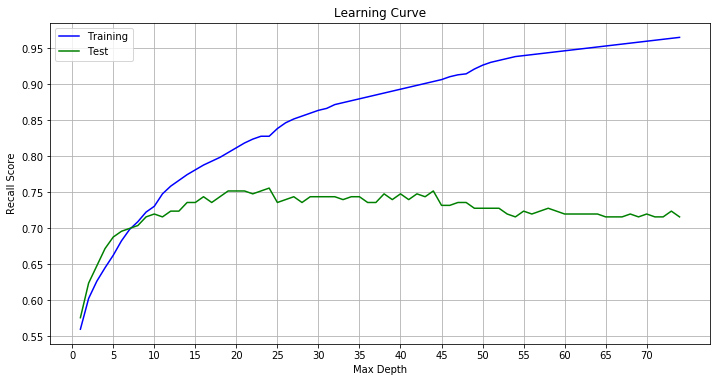

In [58]:
# Graficamos los porcentajes de acierto para cada valor del parámetro max_leaf_nodes.
## Buscamos un valor que maximice el acierto del conjunto de test, pero que no tenga
## un fuerte sobreaprendizaje sobre el conjunto de entrenamiento.
plt.plot(
    mono_tfidf_depth,
    mono_tfidf_trainrc, 
    color = 'b', 
    label = 'Training')

plt.plot(
    mono_tfidf_depth,
    mono_tfidf_testrc, 
    color = 'g', 
    label = 'Test')


plt.title('Learning Curve')
plt.xlabel('Max Depth')
plt.xticks(range(0,75,5))
plt.ylabel('Recall Score')
plt.legend( loc = 'best' )
plt.grid()
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54]
plt.show()

In [59]:
# Buscamos el valor óptimo para el conjunto de test.
mono_tfidf_optdepth = np.argmax(mono_tfidf_testrc) + 1
print('Profundidad máxima óptima:', mono_tfidf_optdepth)
print("Porcentaje de acierto en entrenamiento:", mono_tfidf_trainrc[mono_tfidf_optdepth - 1])
print("Porcentaje de acierto en test:", mono_tfidf_testrc[mono_tfidf_optdepth - 1])

Profundidad máxima óptima: 24
Porcentaje de acierto en entrenamiento: 0.828
Porcentaje de acierto en test: 0.756


Como podemos observar en la gráfica, ambos porcentajes de acierto presentan una disposición parecida a la de anteriores vectorizaciones.

En este caso, el acierto en test crece rápidamente hasta la profundidad 15, a partir de la cual oscila en el intervalo de valores (0.73, 0.76) hasta la profundidad 45. A partir de ahí, comienza a descender, estabilizándose en torno a un acierto de 0.72.

Por otro lado, el acierto en entrenamiento evoluciona de forma análoga a las gráficas de las vectorizaciones anteriores.

Para el valor óptimo de profundidad (24), tenemos un 75.6 % de acierto en el conjunto de test y un 82.8 % de acierto en el conjunto de entrenamiento; es decir, el árbol presenta algo de sobreaprendizaje, pero mucho menor que para el segundo valor óptimo en la profundidad 44.

#### max_depth = 24

In [60]:
# Árbol de decisión con max_leaf_nodes = 18.
mono_tfidf_opttree = tree.DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 24,
    random_state = 7
    )

In [61]:
## Ajustamos el árbol al conjunto de datos.
mono_tfidf_opttree.fit(mono_tfidf_trainpp, train_data_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=24, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [62]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
mono_tfidf_opttree_trainp = mono_tfidf_opttree.predict(mono_tfidf_trainpp)
mono_tfidf_opttree_testp = mono_tfidf_opttree.predict(mono_tfidf_testpp)

In [63]:
## Calculamos los porcentajes de acierto.
mono_tfidf_opttree_trainscr = np.mean(mono_tfidf_opttree_trainp == train_data_target)
mono_tfidf_opttree_testscr = np.mean(mono_tfidf_opttree_testp == test_data_target)

print("VECTORIZACIÓN III: ÁRBOL DE DECISIÓN")
print("Porcentaje de aciertos en entrenamiento:", mono_tfidf_opttree_trainscr)
print("Porcentaje de aciertos en test:", mono_tfidf_opttree_testscr)

VECTORIZACIÓN III: ÁRBOL DE DECISIÓN
Porcentaje de aciertos en entrenamiento: 0.828
Porcentaje de aciertos en test: 0.756


## 3.4. Vectorización IV.

En este caso, el procedimiento es análogo al de la vectorización 3, pues las únicas diferencias que encontraremos serán las generadas por la presencia de bigramas.

Por tanto, repetimos lo anterior, creando un clasificadores Naive Bayes Gaussiano; y hallando el valor óptimo del parámetro del árbol de decisión.

In [64]:
# Vectorizamos los datos del conjunto de entrenamiento.
duo_tfidf_trainvd = duo_tfidf_vectorizer.fit_transform(train_data)

In [65]:
# Obtenemos un transformador TF-IDF.
duo_tfidfer = TfidfTransformer()

In [66]:
# Recalculamos la matriz utilizando el transformador.
duo_tfidf_trainpp = duo_tfidfer.fit_transform(duo_tfidf_trainvd)

In [67]:
## Nos quedan los datos de la bolsa de palabras transformados por TF-IDF.
## Nos quedan datos tipo "float" en forma de matriz dispersa.
print(duo_tfidf_trainpp.dtype)
print(duo_tfidf_trainpp[:3])

float64
  (0, 3735)	0.35347887825229474
  (0, 3733)	0.3067298400341008
  (0, 2916)	0.35347887825229474
  (0, 2903)	0.24429297099977945
  (0, 1872)	0.35347887825229474
  (0, 1871)	0.3327920992904226
  (0, 1707)	0.3327920992904226
  (0, 993)	0.35347887825229474
  (0, 992)	0.35347887825229474
  (1, 3972)	0.4559647094522396
  (1, 3969)	0.4103470908103759
  (1, 3230)	0.4559647094522396
  (1, 1065)	0.4559647094522396
  (1, 1064)	0.4559647094522396
  (2, 2335)	0.4654825222608925
  (2, 1376)	0.49441750620178954
  (2, 1370)	0.22356209462529167
  (2, 123)	0.49441750620178954
  (2, 122)	0.49441750620178954


In [68]:
# Procedemos de forma análoga con el conjunto de test.
## Para los conjuntos de test no hace falta "fit", pues usamos el vocabulario
## encontrado en el conjunto de entrenamiento.
duo_tfidf_testvd = duo_tfidf_vectorizer.transform(test_data)
duo_tfidf_testpp = duo_tfidfer.transform(duo_tfidf_testvd)

### 3.4.1. Vectorización IV: Naive Bayes.

#### Naive Bayes: Gaussiano

In [69]:
# Clasificador Naive Bayes de tipo Gaussiano.
## Asume una distribución Normal.
duo_tfidf_gnbclass = GaussianNB(
    priors = None, # La probabilidad de cada clase seguirá una distribución uniforme
    var_smoothing = 1e-9 # Valor añadido de suavizado para evitar probabilidades nulas (1e-9 por defecto)
)

In [70]:
# Ajustamos el clasificador a los datos transformados por TF-IDF.
duo_tfidf_gnbclass.fit(
    duo_tfidf_trainpp.toarray(),
    train_data_target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [71]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
duo_tfidf_gnb_trainp = duo_tfidf_gnbclass.predict(duo_tfidf_trainpp.toarray())
duo_tfidf_gnb_testp = duo_tfidf_gnbclass.predict(duo_tfidf_testpp.toarray())

In [72]:
# Obtenemos las medias de acierto del clasificador para entrenamiento test.
duo_tfidf_gnb_trainscr = np.mean(duo_tfidf_gnb_trainp == train_data_target)
duo_tfidf_gnb_testscr = np.mean(duo_tfidf_gnb_testp == test_data_target)

print("VECTORIZACIÓN IV: GAUSSIAN NB")
print("Porcentaje de aciertos en entrenamiento:", duo_tfidf_gnb_trainscr)
print("Porcentaje de aciertos en test:", duo_tfidf_gnb_testscr)

VECTORIZACIÓN IV: GAUSSIAN NB
Porcentaje de aciertos en entrenamiento: 0.976
Porcentaje de aciertos en test: 0.672


**Conclusión.**

En primer lugar, los porcentajes de acierto quedan así:

|  Vect. IV   | % train | % test |
|------------:|--------:|-------:|
|  Gaussiano  |   97.6  |  67.2  |

Aunque mejor que la anterior vectorización, este clasificador también presenta un acierto en test mediocre, de un 67.2 %. Por otra parte, el acierto en entrenamiento es de 97.6 %, lo que representa un sobreaprendizaje extremo.

Nos encontramos por tanto en una situación análoga a la anterior vectorización, en que seguramente la vectorización no binaria haya perjudicado la precisión en el conjunto de test.

### 3.4.2. Vectorización IV: Árbol de Decisión.

In [73]:
# Construimos árboles de decisión en función del parámetro max_leaf_nodes.
duo_tfidf_trainrc = []
duo_tfidf_testrc = []

duo_tfidf_depth = range(1,75)
for depth in duo_tfidf_depth:
    clfCheck = tree.DecisionTreeClassifier(
        criterion = 'gini',
        max_depth = depth,
        random_state = 7)
    
    clfCheck.fit(duo_tfidf_trainpp, train_data_target)
    
    y_train_prediction = clfCheck.predict(duo_tfidf_trainpp)
    y_test_prediction = clfCheck.predict(duo_tfidf_testpp)
    
    train_scr = recall_score(train_data_target, y_train_prediction, average = "micro")
    test_scr = recall_score(test_data_target, y_test_prediction, average = "micro")
    
    duo_tfidf_trainrc.append(train_scr)
    duo_tfidf_testrc.append(test_scr)

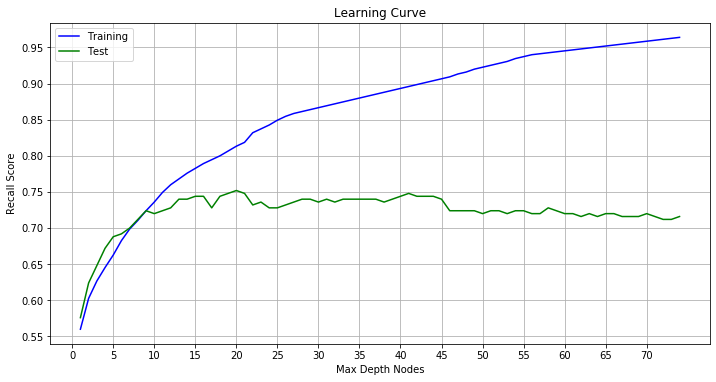

In [74]:
# Graficamos los porcentajes de acierto para cada valor del parámetro max_leaf_nodes.
plt.plot(
    duo_tfidf_depth,
    duo_tfidf_trainrc, 
    color = 'b', 
    label = 'Training')

plt.plot(
    duo_tfidf_depth,
    duo_tfidf_testrc, 
    color = 'g', 
    label = 'Test')


plt.title('Learning Curve')
plt.xlabel('Max Depth Nodes')
plt.xticks(range(0,75,5))
plt.ylabel('Recall Score')
plt.legend( loc = 'best' )
plt.grid()
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54]
plt.show()

In [75]:
# Buscamos el valor óptimo para el conjunto de test.
duo_tfidf_optdepth = np.argmax(duo_tfidf_testrc) + 1
print('Profundidad máxima óptima:', duo_tfidf_optdepth)
print("Porcentaje de acierto en entrenamiento:", duo_tfidf_trainrc[duo_tfidf_optdepth - 1])
print("Porcentaje de acierto en test:", duo_tfidf_testrc[duo_tfidf_optdepth - 1])

Profundidad máxima óptima: 20
Porcentaje de acierto en entrenamiento: 0.8133333333333334
Porcentaje de acierto en test: 0.752


Como podemos observar en la gráfica, los porcentajes de acierto vuelven a presentar una disposición análoga a la del resto de vectorizaciones.

En este caso, el acierto en test replica el rápido crecimientohasta la profundidad 15, manteniéndose  en el intervalo de valores (0.73, 0.75) hasta la profundidad 45, tras la cual desciende y se estabiliza alrededor de un acierto de 0.72.

Para el valor óptimo de profundidad (20), tenemos un 75.2 % de acierto en el conjunto de test y un 81.3 % de acierto en el conjunto de entrenamiento; es decir, el árbol presenta algo de sobreaprendizaje que vuelve a ser mucho menor que para el segundo valor óptimo en la profundidad 41.

#### max_depth = 20

In [76]:
# Árbol de decisión con max_leaf_nodes = 18.
duo_tfidf_opttree = tree.DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 20,
    random_state = 7
    )

In [77]:
## Ajustamos el árbol al conjunto de datos.
duo_tfidf_opttree.fit(duo_tfidf_trainpp, train_data_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [78]:
# Obtenemos las predicciones respecto a los conjuntos de entrenamiento y test.
duo_tfidf_opttree_trainp = duo_tfidf_opttree.predict(duo_tfidf_trainpp)
duo_tfidf_opttree_testp = duo_tfidf_opttree.predict(duo_tfidf_testpp)

In [79]:
## Calculamos los porcentajes de acierto.
duo_tfidf_opttree_trainscr = np.mean(duo_tfidf_opttree_trainp == train_data_target)
duo_tfidf_opttree_testscr = np.mean(duo_tfidf_opttree_testp == test_data_target)

print("VECTORIZACIÓN IV: ÁRBOL DE DECISIÓN")
print("Porcentaje de aciertos en entrenamiento:", duo_tfidf_opttree_trainscr)
print("Porcentaje de aciertos en test:", duo_tfidf_opttree_testscr)

VECTORIZACIÓN IV: ÁRBOL DE DECISIÓN
Porcentaje de aciertos en entrenamiento: 0.8133333333333334
Porcentaje de aciertos en test: 0.752


## 4. Análisis conjunto de las tasas de acierto.

### 4.1. Clasificadores Naive Bayes.

__*Selecciona el mejor clasificador Naive Bayes y obtén las 25 varialbes con más presencia en cada clase*__

In [80]:
print('Tasas de acierto de los clasificadores Naive Bayes.')
print('Vect. I:', (mono_bin_mnb_trainscr, mono_bin_mnb_testscr))
print('Vect. II:', (duo_bin_mnb_trainscr, duo_bin_mnb_testscr))
print('Vect. III:', (mono_tfidf_gnb_trainscr, mono_tfidf_gnb_testscr))
print('Vect. IV:', (duo_tfidf_gnb_trainscr, duo_tfidf_gnb_testscr))

Tasas de acierto de los clasificadores Naive Bayes.
Vect. I: (0.9573333333333334, 0.756)
Vect. II: (0.98, 0.76)
Vect. III: (0.948, 0.652)
Vect. IV: (0.976, 0.672)


Los porcentajes de acierto para los clasificadores Naive Bayes quedan:

|  Naive Bayes   | % train | % test |
|---------------:|--------:|-------:|
|  Vect. I       |   95.7  |  75.6  |
|  Vect. II      |   98.0  |  76.0  |
|  Vect. III     |   94.8  |  65.2  |
|  Vect. IV      |   97.6  |  67.2  |

Por tanto, el clasificador que maximiza el porcentaje de acierto en el conjunto de test es el de la vectorización II.

Este clasificador es de tipo Multinomial, y está construido sobre una bolsa de palabras binaria de monogramas y bigramas.

In [81]:
# A continuación vemos las 25 variables con más presencia en la clase '0'.
## El atributo 'feature_count_' del clasificador nos da las frecuencias de cada término 
## por cada clase. Por tanto, para hallar las variables con más presencia en cada clase,
## basta con tomar los índices reordenados de mayor a menor frecuencia.
neg_relevant_fn_idx = sorted(
            list(enumerate(duo_bin_mnbclass.feature_count_[0])),
            key = lambda x: x[1],
            reverse = True
        )

neg_relevant_fn_idx[:5]

[(1370, 46.0), (2770, 41.0), (3390, 29.0), (2109, 23.0), (1021, 18.0)]

In [82]:
# Obtenemos los n-gramas asociados a esos índices.
neg_relevant_fn = list(map(
    lambda x: (x[1], duo_bin_vectorizer.get_feature_names()[x[0]]), 
    neg_relevant_fn_idx[:25]
))

In [83]:
print('25 términos con más frecuencia en críticas negativas:')
for val, term in neg_relevant_fn:
    print(val, '->', term)

25 términos con más frecuencia en críticas negativas:
46.0 -> food
41.0 -> place
29.0 -> service
23.0 -> like
18.0 -> don
16.0 -> good
15.0 -> time
14.0 -> ve
13.0 -> just
12.0 -> minutes
12.0 -> think
12.0 -> won
11.0 -> bad
11.0 -> disappointed
11.0 -> got
11.0 -> worst
10.0 -> going
9.0 -> came
9.0 -> did
9.0 -> eat
9.0 -> flavor
9.0 -> really
9.0 -> wait
9.0 -> wasn
9.0 -> way


In [84]:
# A continuación vemos las 25 variables con más presencia en la clase '1'.
pos_relevant_fn_idx = sorted(
    list(enumerate(duo_bin_mnbclass.feature_count_[1])),
    key = lambda x: x[1],
    reverse = True
)

In [85]:
# Obtenemos los n-gramas asociados a esos índices.
pos_relevant_fn = list(map(
    lambda x: (x[1], duo_bin_vectorizer.get_feature_names()[x[0]]), 
    pos_relevant_fn_idx[:25]
))

In [86]:
print('25 términos con más frecuencia en críticas positivas:')
for val, term in pos_relevant_fn:
    print(val, '->', term)

25 términos con más frecuencia en críticas positivas:
50.0 -> good
45.0 -> great
42.0 -> food
38.0 -> place
33.0 -> service
17.0 -> delicious
17.0 -> friendly
16.0 -> nice
15.0 -> best
15.0 -> just
15.0 -> time
14.0 -> really
13.0 -> amazing
12.0 -> restaurant
12.0 -> vegas
11.0 -> staff
10.0 -> fantastic
10.0 -> like
10.0 -> love
9.0 -> excellent
9.0 -> pretty
8.0 -> chicken
8.0 -> definitely
8.0 -> fresh
8.0 -> loved


__*¿Tienen sentido las palabras seleccionadas? ¿Hay ruido: palabras sin sentimiento o de sentimiento opuesto al esperado? ¿Por qué crees que suceden estos fenómenos?*__

Para la clase de críticas negativas (0), nos encontramos con bastantes palabras que, a priori, no transmiten sentimiento. Sean estas:

    Clase 0 (negativa)   
    1. food
    2. place
    3. service
    5. don
    7. time
    9. just
    10. minutes
    11. think
    12. won
    15. got
    17. going
    18. came
    19. did
    20. eat
    21. flavor
    22. really
    23. wait
    25. way
    (18 / 25 palabras)
    
Una explicación para la presencia de este tipo de palabras es que, sin hacer valoraciones de forma explícita, las mensajes negativos sustenten su crítica en determinados temas; es decir, el cliente no comunica sólo que ha tenido una mala experiencia, sino las razones por las que ha sido así.

De esta forma, tenemos palabras muy ambiguas en este sentido, como *food, place, service, time...*. Estos términos encajan perfectamente en mensajes negativos que, por ejemplo, se quejen de: la comida (food, flavor, eat); el lugar (place), ya sea de mesa o de localización en el establecimiento; la calidad del servicio de los camareros (service); o el retraso en traer la comida (time, minutes, wait).

Nos referimos a estas palabras como ambiguas porque, al igual que sirven para detallar quejas, también pueden estar incluidas como cumplidos en mensajes positivos. Así, algunas de estas palabras 'temáticas' aparecen también en las 25 palabras más relevantes de la clase (1).

    Clase 1 (positiva)
    3. food
    4. place
    5. service
    10. just
    11. time
    12. really
    
Sin embargo, a pesar de que no abundan, también hay algunas palabras con sentimiento entre las de clase (0).

    Clase 0 (negativa)
    4. like
    6. good
    13. bad
    14. disappointed
    16. worst
    24. wasn
    
Y aquí también, aunque hay 4 de ellas con un cariz claramente negativo, las dos primeras transmiten sensaciones buenas. Una posible explicación a esto es que las críticas negativas no tienen que ser enteramente 'destructivas', en el sentido de que el cliente también puede observaciones positivas dentro de su mala experiencia.

Por otra parte, en la clase de críticas positivas (1) podemos encontrar un número mayor de palabras con sentimiento, que reflejan inequívocamente buenas sensaciones.

    Clase 1 (positiva)
    1. good
    2. great
    6. delicious
    7. friendly
    8. nice
    9. best
    13. amazing
    17. fantastic
    18. like
    19. love
    20. excellent
    21. pretty
    24. fresh
    25. loved
    (14 / 25 palabras)
    
Abundan las palabras que expresan de forma directa sentimientos positivos: good, great, nice, best, amazing, fantastic, like, love, excellent, pretty, loved. Pero también hay otras como: delicious, friendly, fresh; que con toda seguridad se emplean para describir experiencias buenas por parte del cliente.

Finalmente, cabe resaltar una serie de palabras que son directamente ruido, pues estas no se pueden asociar sin contexto a sentimientos positivos. Las siguientes palabras no transmiten nada por sí solas, pues distintos adjetivos pueden determinar sentimientos positivos o negativos: restaurant, staff, chicken, definitely. Y la palabra *vegas* carece completamente de contexto, pues puede referirse tanto a una localización como a un plato del menú; es decir, es totalmente irrelevante, aunque aparece lo suficiente en el conjunto de entrenamiento como para tener tal importancia.
    
    Clase 1 (positiva)
    14. restaurant
    15. vegas
    16. staff
    22. chicken
    23. definitely

### 4.2. Árboles de decisión.

__*Selecciona el mejor árbol de decisión y botén las 25 variables con más poder discriminante.*__

In [87]:
print('Tasas de acierto de los árboles de decisión.')
print('Vect. I:', (mono_bin_opttree_trainscr, mono_bin_opttree_testscr))
print('Vect. II:', (duo_bin_opttree_trainscr, duo_bin_opttree_testscr))
print('Vect. III:', (mono_tfidf_opttree_trainscr, mono_tfidf_opttree_testscr))
print('Vect. IV:', (duo_tfidf_opttree_trainscr, duo_tfidf_opttree_testscr))

Tasas de acierto de los árboles de decisión.
Vect. I: (0.8573333333333333, 0.764)
Vect. II: (0.7866666666666666, 0.756)
Vect. III: (0.828, 0.756)
Vect. IV: (0.8133333333333334, 0.752)


Los porcentajes de acierto para los árboles de decisión quedan:

|  Decision Tree | % train | % test | depth |
|---------------:|--------:|-------:|------:|
|  Vect. I       |   85.7  |  76.4  |   35  |
|  Vect. II      |   78.7  |  75.6  |   16  |
|  Vect. III     |   82.8  |  75.6  |   24  |
|  Vect. IV      |   81.3  |  75.2  |   20  |

Por tanto, el árbol de decisión que maximiza el porcentaje de acierto en el conjunto de test es el de la vectorización I.

Este árbol tiene profundidad máxima 35, y está construido sobre una bolsa de palabras binaria de monogramas.

In [88]:
# A continuación vemos las 25 variables con más poder discriminante.
## Utilizamos el atributo 'feature_importances_' del clasificador del árbol de decisión,
## que devuelve, para cada variable, la reducción total normalizada del criterio Gini que
## genera esa variable.
besttree_relevant_fn_idx = sorted(
    list(enumerate(mono_bin_opttree.feature_importances_)),
    key = lambda x: x[1],
    reverse = True
)

besttree_relevant_fn_idx[:5]

[(581, 0.11314090280693595),
 (569, 0.05288616469843934),
 (340, 0.04554521583515213),
 (34, 0.041275506639947855),
 (892, 0.0391510057795566)]

In [89]:
# Obtenemos los n-gramas asociados a esos índices.
besttree_relevant_fn = list(map(
    lambda x: (x[1], mono_bin_vectorizer.get_feature_names()[x[0]]), 
    besttree_relevant_fn_idx[:25]
))

In [90]:
# print('25 términos más discriminantes del árbol de decisión:')
for val, term in besttree_relevant_fn:
    print(val, '->', term)

0.11314090280693595 -> great
0.05288616469843934 -> good
0.04554521583515213 -> delicious
0.041275506639947855 -> amazing
0.0391510057795566 -> nice
0.034457400777363714 -> fantastic
0.02702706160289843 -> perfect
0.02613904226587454 -> friendly
0.026020583755243243 -> vegas
0.025431445134418855 -> excellent
0.025258240459400623 -> awesome
0.024825934535980386 -> loved
0.024479800858154422 -> love
0.0214955103008731 -> wonderful
0.018116158133857516 -> happy
0.017824402041644767 -> best
0.016737434539832625 -> way
0.01412173256031918 -> regular
0.013962167616133886 -> helpful
0.013949516309583656 -> steaks
0.013780431263406893 -> favorite
0.01345786611574442 -> service
0.012574862848290796 -> quite
0.01231612081437554 -> special
0.010969495416715849 -> visit


__*¿Predominan más las palabras de uno u otro sentimiento? ¿Por qué? ¿Hay ruido?*__

Es obvio el fuerte dominio de palabras positivas frente a las demás, y, concretamente, frente aquellas palabras de sentimiento negativo, que ni siquiera aparecen en esta lista de las 25 variables más discriminantes.

    1. great
    2. good
    3. delicious
    4. amazing
    5. nice
    6. fantastic
    7. perfect
    8. friendly
    10. excellent
    11. awesome
    12. loved
    13. love
    14. wonderful
    15. happy
    16. best
    19. helpul
    21. favorite
    24. special
    (18 / 25 palabras)

Por otro lado, el resto de términos de la lista podemos interpretarlo como ruido. Estas palabaras no aportan ninguna información sobre el sentimiento de la crítica y, seguramente, su valor discriminante se debe a un sobreaprendizaje del conjunto de entrenamiento.

    9. vegas
    17. way
    18. regular
    20. steaks
    22. service
    23. quite
    25. visit
    (7 / 25 palabras)
    
Por ejemplo, volvemos a encontrarnos con la palabra *vegas*, cuya presencia es completamente irrelevante y puede deberse, por ejemplo, a que el conjunto de entrenamiento esté sesgado a críticas de restaurantes de Las Vegas, o a restaurantes que sirvan un determinado plato que contenga la palabra *vegas* en su nombre.

Aparecen también palabras ambiguas: steaks, service, visit. Como explciamos antes, éstas son irrelevantes fuera de su contexto, que las discrimina a sentimientos positivos o negativos. Por tanto, su presencia se debe a un sobreaprendizaje del conjunto de entrenamiento.

### 4.3. Análisis conjunto de los 8 clasificadores.

Volvemos a escribir, por un lado, los porcentajes de acierto de los clasificadores Naive Bayes, y por otro, los de los árboles de decisión.

|  Naive Bayes   | % train | % test |
|---------------:|--------:|-------:|
|  Vect. I       |   95.7  |  75.6  |
|  Vect. II      |   98.0  |  76.0  |
|  Vect. III     |   94.8  |  65.2  |
|  Vect. IV      |   97.6  |  67.2  |

|  Decision Tree | % train | % test | depth |
|---------------:|--------:|-------:|------:|
|  Vect. I       |   85.7  |  76.4  |   35  |
|  Vect. II      |   78.7  |  75.6  |   16  |
|  Vect. III     |   82.8  |  75.6  |   24  |
|  Vect. IV      |   81.3  |  75.2  |   20  |


__*¿Hay un clasificador que sea superior a otros? ¿Por qué crees que sucede?*__

Como podemos observar, los mejores clasificadores para el conjunto de test se mueven en porcentajes de acierto en torno a 75-76 %. Hay claramente, dos clasificadores con un rendmiento más bajo en el conjunto de test (65-67 %); estos son los clasificadores Naive Bayes de las vectorizaciones III y IV, es decir, aquellos construidos a partir de las bolsas de palabras no binarias con frecuencias TF/IDF.

Es por ello que, al menos en el caso de los clasificadores Naive Bayes, la complejización de la bolsa de palabras de valores binarios a frecuencias TF/IDF ha resultado ser perjudicial. Esto tiene fácil explicación, pues al encontrarnos en un problema de clasificación de textos con dos clases explícitas y con sentimientos opuestos (negativos y positivos), es la presencia o ausencia de ciertas palabras lo que determina la clase del texto. Por tanto, tomar la frecuencia relativa de las palabras resulta perjudicial para resolver este problema.

Con respecto a los árboles de decisión, no tiene lugar el contraste anterior, pues los 4 árboles de decisión presentan porcentajes de acierto en test en torno a 75-77 %. La única diferencia en estos árboles es el acierto en el conjunto de entrenamiento.

No obstante, como hemos observado en el análisis particular de cada vectorización, los gráficos de cada árbol tomando por parámetro la profundidad máxima presentaban *mesetas* en el porcentaje de acierto con valores por encima del 75 %. Es decir, eligiendo árboles subóptimos en cada caso, podríamos reducir el sobreaprendizaje del árbol, manteniendo el acierto de test en un umbral aceptable, con profundidades máximas más pequeñas.

Este es el caso del árbol de decisión de la vectorización II, en el cuál el valor óptimo de acierto en test se ha alcanzado pronto en esta *meseta*, lo que ha dado el menor acierto en entrenamiento de entre los 4 árboles de decisión: 78.7 %.

La ausencia de contraste entre los árboles formados de bolsas binarias y los entrenados a partir de bolsas TF/IDF se debe a la distinta forma de clasificar de los árboles de decisión frente a los clasificadores Naive Bayes.

Es más, puesto que los datos están estratificados a 50/50, la mayoría de los mensajes positivos contendrán las mismas palabras positivas, por lo que estas palabras tendrán porcentajes de aparición en mensajes parecidas (es decir, denominadores parecidos en el cálculo de la TF/IDF). Es por ello que, seguramente, esta configuración determine umbrales de valores TF/IDF para las palabras positivas, que acaben siendo análogos a valores binarios.

Finalmente, comentamos también la diferencia entre bolsas de palabras con o sin bigramas. En efecto, en los clasificadores Naive Bayes vemos una ligera mejora de las vectorizaciones con bigramas y monogramas frente a aquellas que contienen únicamente monogramas. 

De la vectorización I a la II hay un aumento de 2.3 puntos en entrenamiento (95.7 -> 98.0) y de 0.4 puntos en test (75.6 -> 76.0).

De la vectorización III a la IV hay un aumento de 2.8 puntos en entramiento (94.8 -> 97.6) y de 2.0 puntos en test (65.2 -> 67.2).

Las mejoras en el conjunto de test son debidas a la aparición de nuevos bigramas, términos de 2 palabras, que transmiten un claro sentimiento positivo o negativo. No obstante, que estos aumentos sean mayores para el conjunto de entrenamiento deja entrever que la introducción de estos bigramas induce también un mayor sobreaprendizaje en los clasificadores Naive Bayes.

Para los árboles de decisión, la presencia o ausencia de bigramas es, en la práctica, irrelevante. Esto confirma que, a pesar de la introducción de bigramas con sentimiento explícito, estos, o no añaden suficientes términos como para ser relevantes, o las palabras por las que están compuestas ya transmiten suficiente sentimiento por sí solas como para hacer al bigrama irrelevante.

## 5. Análisis del clasificador Naive Bayes óptimo.

Para los clasificadores Naive Bayes, hemos elegido el que consigue un acierto mayor para el conjunto de test: el que se da con la vectorización II.

El vectorizador II es *duo_bin_vectorizer*, con vectorización *duo_bin_trainvd* para entrenamiento y *duo_bin_testvd* para test.

El clasificador multinomial asociado es *duo_bin_mnbclass*.

Las predicciones para entrenamiento son *duo_bin_mnb_trainp* y para test son *duo_bin_mnb_testp*.

### 5.1. Precisión y exhaustividad.

In [91]:
duo_bin_mnb_classrep = classification_report(
    test_data_target,
    duo_bin_mnb_testp,
    target_names = ['negative', 'positive']
)

In [92]:
print(duo_bin_mnb_classrep)

              precision    recall  f1-score   support

    negative       0.78      0.73      0.75       125
    positive       0.74      0.79      0.77       125

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250



__*¿Hay un comportamiento homogéneo a la hora de clasificar ambas clases? ¿Cuáles son las fortalezas y debilidades del clasificador?*__

Respecto a la precisión, el clasificador posee más precisión para mensajes negativos frente a mensajes positivos (78 % frente a 74 % de precisión).

No obstante, se equivoca menos al clasificar correctamente mensajes positivos frente a la clasificación de los negativos (79 % frente a 73 % de exhaustividad).

Es decir, se darán más *falsos predicciones* del tipo (Predicción positiva, mensaje negativo) frente a los de (Predicción negativa, mensaje positivo).

### 5.2. Análisis concreto de falsas predicciones.

In [93]:
# Función para clasificar falsas predicciones.
def get_pred_errors(prediction, target):
    errors = list()
    for pred, targ in zip(prediction,  target):
        if pred == 0:
            if targ == 0:
                errors.append(0)
            else:
                errors.append(1)
        else: # pred == 1
            if targ == 1:
                errors.append(0)
            else:
                errors.append(-1)
                
    return errors

In [94]:
# Clasificamos el vector de predicción de test.
duo_bin_mnb_testpe_idx = list(enumerate( get_pred_errors(duo_bin_mnb_testp, test_data_target) ))

#### Negativo clasificado positivo.

In [95]:
# Obtenemos 2 críticas negativas clasificadas como positivas (-1)
mnb_neg_as_pos = shuffle(
    [x[0] for x in duo_bin_mnb_testpe_idx if x[1] == -1],
    n_samples = 2,
    random_state = 7,
)

#### Mensaje 1. Negativo clasificado positivo.

In [96]:
# Texto de la crítica.
mnb_badpred1 = test_data[mnb_neg_as_pos[0]]
mnb_badpred1

'If you look for authentic Thai food, go else where.'

In [97]:
# Vectorización de la crítica.
mnb_badpred1_vd = duo_bin_testvd[mnb_neg_as_pos[0]]
print(mnb_badpred1_vd)

  (0, 161)	1
  (0, 165)	1
  (0, 1370)	1
  (0, 2189)	1
  (0, 3843)	1


In [98]:
# Obtenemos los términos de la vectorización.
for idx in mnb_badpred1_vd.indices:
    print(duo_bin_vectorizer.get_feature_names()[idx])

authentic
authentic thai
food
look
thai


La ambigüedad de este mensaje es trivial. Tenemos una serie de palabras triviales, siendo las de más importancia *food* y *look*, que están ambas presentes en las 25 variables con más presencia en cada clase. Es decir, son palabras ambiguas que pueden conducir a error al clasificador.

No obstante, también tenemos la palabra *authentic* que, aunque no aparece entre las 25 primeras variables de la clase de críticas positivas, sí que desprende un sentimiento positivo, lo que ha podido hacer que el clasificador la categorice como una opinión positiva.

Sin embargo, la crítica traducida es "Si estás buscando un (restaurante) thai auténtico, ve a otro sitio.". Esta es claramente negativa, pero la condicionalidad de la frase lleva al calsificador a error.

Como vemos, el resto de palabras no se encuentran en la vectorización porque corresponden a palabras vacías. Quizá, si hubiese podido vectorizarse el bigrama "else where", el clasificador habría actuado correctamente, pero ese bigrama nunca podrá estar en el diccionario por nuestra configuración inicial de palabras vacías.

#### Mensaje 2. Negativo clasificado positivo.

In [99]:
# Texto de la crítica.
mnb_badpred2 = test_data[mnb_neg_as_pos[1]]
mnb_badpred2

'-My order was not correct.'

In [100]:
# Vectorización de la crítica.
mnb_badpred2_vd = duo_bin_testvd[mnb_neg_as_pos[1]]
print(mnb_badpred2_vd)

  (0, 2563)	1


In [101]:
# Obtenemos los términos de la vectorización.
for idx in mnb_badpred2_vd.indices:
    print(duo_bin_vectorizer.get_feature_names()[idx])

order


La razón de la equivocación en este caso es bastante obvia: el clasificador sólo tiene una palabra para categorizar el mensaje. Además, se trata de una palabra ambigua como *order*.

Por otro lado, aunque hay otra palabra que, a priori, no debería estar en el conjunto de palabras vacías, es posible que esta no estuviese contenida en ningún texto del conjunto de entrenamiento y, por tanto, no se halla añadido al vocabulario de la vectorización.

Aún así, la palabra *order* habría tenido un cariz positivo. Por tanto, que algunas palabras cono *not* no se cuenten porque se toman como palabras vacías puede perjudicar el rendimiento del clasificador, pues contar el número de expresiones con negación podría ayudar a clasificar mejor críticas negativas.

#### Positivo clasificado negativo.

In [102]:
# Obtenemos 2 críticas negativas clasificadas como positivas (-1)
mnb_pos_as_neg = shuffle(
    [x[0] for x in duo_bin_mnb_testpe_idx if x[1] == 1],
    n_samples = 2,
    random_state = 7,
)

#### Mensaje 1. Positivo clasificado negativo.

In [103]:
# Texto de la crítica.
mnb_badpred3 = test_data[mnb_pos_as_neg[0]]
mnb_badpred3

'Also there are combos like a burger, fries, and beer for 23 which is a decent deal.'

In [104]:
# Vectorización de la crítica.
mnb_badpred3_vd = duo_bin_testvd[mnb_pos_as_neg[0]]
print(mnb_badpred3_vd)

  (0, 278)	1
  (0, 454)	1
  (0, 827)	1
  (0, 833)	1
  (0, 1479)	1
  (0, 2109)	1


In [105]:
# Obtenemos los términos de la vectorización.
for idx in mnb_badpred3_vd.indices:
    print(duo_bin_vectorizer.get_feature_names()[idx])

beer
burger
deal
decent
fries
like


En este caso, nos encontramos con un mensaje repleto de palabras, por sí solas, ambiguas. Esto ha llevado al clasificador a equivocarse y categorizar el mensaje como negativo.

Una buena clasificación habría implicado 'comprender' al menos el significado de la parte 'which is a decent deal'. Esto podría haber sido posible de encontrarse en el vocabulario el bigrama 'decent deal', que tiene una obvia connotación positiva. No obstante, como en el mensaje anterior, este bigrama no ha debido encontrarse en el conjunto de entrenamiento.

#### Mensaje 2. Positivo clasificado negativo.

In [106]:
# Texto de la crítica.
mnb_badpred4 = test_data[mnb_pos_as_neg[1]]
mnb_badpred4

"Point your finger at any item on the menu, order it and you won't be disappointed."

In [107]:
# Vectorización de la crítica.
mnb_badpred4_vd = duo_bin_testvd[mnb_pos_as_neg[1]]
print(mnb_badpred4_vd)

  (0, 970)	1
  (0, 2343)	1
  (0, 2563)	1
  (0, 2850)	1
  (0, 4281)	1
  (0, 4284)	1


In [108]:
# Obtenemos los términos de la vectorización.
for idx in mnb_badpred4_vd.indices:
    print(duo_bin_vectorizer.get_feature_names()[idx])

disappointed
menu
order
point
won
won disappointed


En este último mensaje, encontramos una palabra explícitamente negativo como *disappointed*. No obstante, también tenemos el bigrama *won disappointed*, que difícilmente ha podido incluirse en el diccionario de una cadena que no fuese 'won't be disappointed', que expresa un sentimiento positivo.

Aún así, el clasificador ha categorizado el mensaje como negativo. Esto puede deberse al mayor peso de la palabra negativo *disappointed* sobre el bigrama anterior o, quizá, a la ausencia de palabras de sentimiento positivo.

## 6. Análisis del árbol de decisión óptimo.

Para los árboles de decisión, hemos elegido el que consigue un acierto mayor para el conjunto de test: el que se da con la vectorización I.

El vectorizador I es *mono_bin_vectorizer*, con vectorización *mono_bin_trainvd* para entrenamiento y *mono_bin_testvd* para test.

El árbol de decisión asociado es *mono_bin_opttree*.

Las predicciones para entrenamiento son *mono_bin_opttree_trainp* y para test son *mono_bin_opttree_testp*.

### 6.1. Precisión y exhaustividad.

In [109]:
mono_bin_opttree_classrep = classification_report(
    test_data_target,
    mono_bin_opttree_testp,
    target_names = ['negative', 'positive']
)

In [110]:
print(mono_bin_opttree_classrep)

              precision    recall  f1-score   support

    negative       0.72      0.86      0.78       125
    positive       0.82      0.67      0.74       125

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.76       250



__*¿Hay un comportamiento homogéneo a la hora de clasificar ambas clases? ¿Cuáles son las fortalezas y debilidades del clasificador?*__

Respecto a la precisión, el clasificador posee más precisión para mensajes positivos frente a mensajes negativos (82 % frente a 72 % de precisión).

No obstante, se equivoca menos al clasificar correctamente mensajes negativos frente a la clasificación de los positivos (86 % frente a 67 % de exhaustividad).

Es decir, se darán más *falsas predicciones* del tipo (Predicción negativa, mensaje positivo) frente a los de (Predicción postiva, mensaje negativo).

### 6.2. Gráfico del árbol.

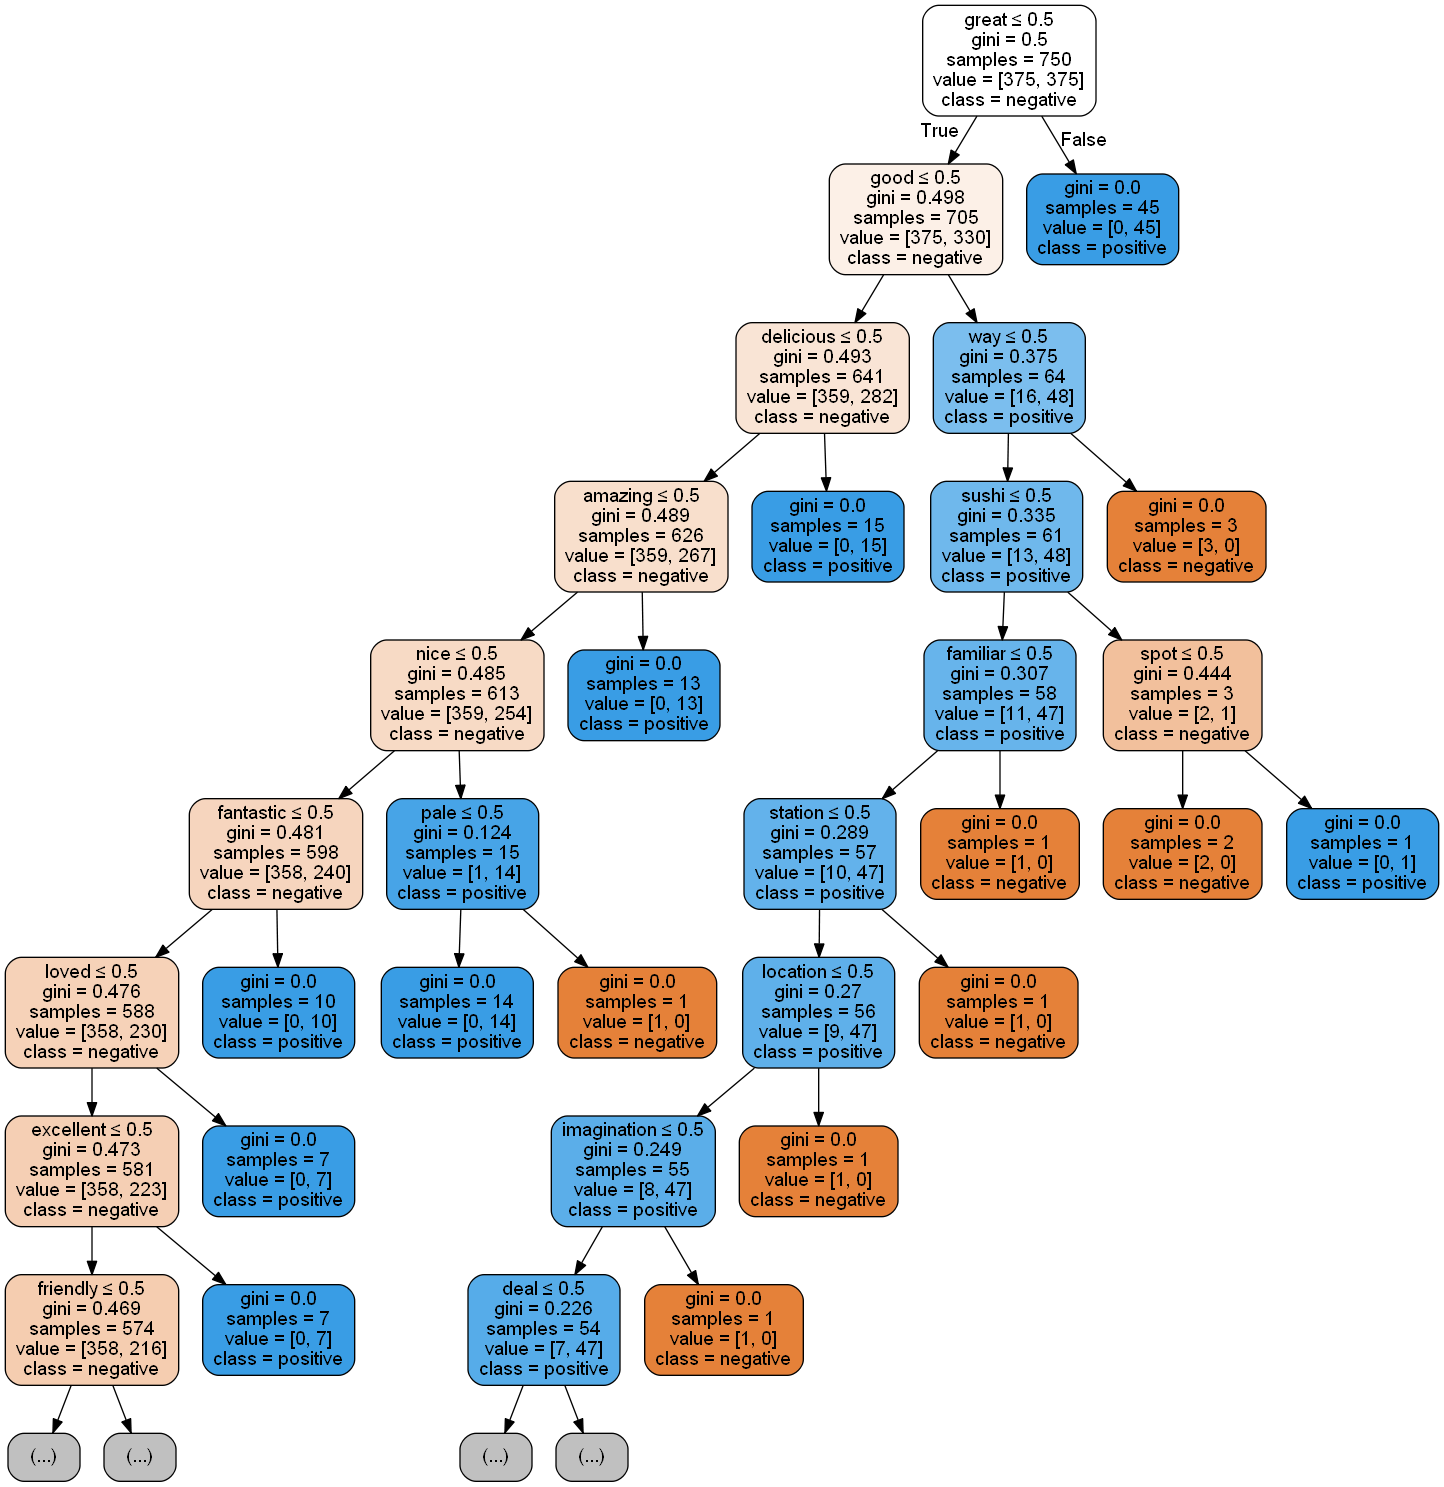

In [111]:
# Graficos los primeros 8 niveles del árbol de decisión.
mono_bin_opttree_graph = tree.export_graphviz(
    mono_bin_opttree,
    out_file = None,
    max_depth = 8,
    feature_names = mono_tfidf_vectorizer.get_feature_names(),
    class_names = ['negative', 'positive'],
    filled = True,
    rounded = True,
    special_characters = True
    )


mbot = gvz.Source(mono_bin_opttree_graph, format = 'png')
mbot.render('mbot')
display(Image(filename = 'mbot.png'))

__*¿Qué estructura tiene el árbol?*__

Por los 8 primeros niveles, el árbol está 'inclinado' a la izquierda, habiendo algunos subárboles más equilibrados como el que hijo del nodo 'nice', más simple, o el hijo del nodo 'good', de mayor complejidad.

__*¿Cómo interpretas los niveles que has pintado? ¿Tiene algún sentido con respecto a la tasa de aciertos o la precisión y exhaustividad del clasificador?*__

Como podemos ver por la sucesión de términos de los hijos izquierdos: 

    great
    good
    delicious
    amazing
    nice
    fantastic
    loved
    excellent
    friendly
    
Se deriva que el árbol de decisión funciona buscando palabras de sentimiento positivo en el mensaje. En la mayoría de estos nodos, si las encuentra, clasifica el mensaje directamente como una crítica positiva. No obstante, en un par de ellas, deriva a subárboles.

En el nodo 'nice', deriva a un subárbol de profundidad 2 en el que se busca la palabra 'pale'. Si la encuentra, entonces clasifica el mensaje como negativo. No obstante, vemos que en ese nodo hoja, sólo hay un mensaje del conjunto de entrenamiento, por lo que este subárbol es claramente despreciable.

En el nodo 'good', nos deriva a un subárbol más complejo. Aparece el término 'way' que podría relacionarse con la expresión 'good way' para señalar críticas negativas (de carácter constructivo). También aparecen palabras irrelevantes como 'sushi' que deriva a la derecha a un subárbol claramente prescindible, pues divide a un nodo [2,1], en un claro ejemplo de sobreaprendizaje. Por el lado izquierdo, nos encontramos una serie de palabras ambiguas con poca capacidad sentimental o ambiguas: station, location, imagination, deal. La palabra *familiar* sí que tiene una connotación positiva.

La inclinación del árbol a buscar palabras positivas en los mensajes para rápidamente clasificarlos como tal si encuentra una de ellas se ve reflejado directamente en los valores de precisión y exhaustividad.

__*¿Hay nodos impuros?*__

Todos los nodos hojas que aparecen contienen mensajes pertenecientes a una única clase. De forma mayoritaria, estos nodos representan mensajes de la clase de críticas positivas.

### 6.3. Análisis concreto de falsas predicciones.

In [112]:
# Clasificamos el vector de predicción de test.
mono_bin_opttree_testpe_idx = list(enumerate( get_pred_errors(mono_bin_opttree_testp, test_data_target) ))

#### Negativo clasificado positivo.

In [113]:
# Obtenemos 2 críticas negativas clasificadas como positivas (-1)
tree_neg_as_pos = shuffle(
    [x[0] for x in mono_bin_opttree_testpe_idx if x[1] == -1],
    n_samples = 2,
    random_state = 7,
)

#### Mensaje 1. Negativo clasificado positivo.

In [114]:
# Texto de la crítica.
tree_badpred1 = test_data[tree_neg_as_pos[0]]
tree_badpred1

'I do love sushi, but I found Kabuki to be over-priced, over-hip and under-services.'

In [115]:
# Vectorización de la crítica.
tree_badpred1_vd = mono_bin_testvd[tree_neg_as_pos[0]]
print(tree_badpred1_vd)

  (0, 642)	1
  (0, 788)	1
  (0, 1036)	1
  (0, 1199)	1
  (0, 1325)	1


In [116]:
# Obtenemos los términos de la vectorización.
for idx in tree_badpred1_vd.indices:
    print(mono_bin_vectorizer.get_feature_names()[idx])

hip
love
priced
services
sushi


Como hemos visto, el árbol de decisión está buscado a la búsqueda de palabra con connotaciones explícitamente positivas. En este mensaje, directamente encontramos la palabra 'love', que, en tanto que también está presente 'loved' en el gráfico de profundidad 8 que hemos analizado, también estará como un nodo que clasifique directamente a mensaje positivo.

Palabras negativas como 'over-priced' o 'under-services' no servirían para el árbol, que sólo busca términos positivos; pero es que además, tampoco están registradas en el vocabulario al no encontrarse en ningún mensaje del conjunto de entrenamiento.

#### Mensaje 2. Negativo clasificado positivo.

In [117]:
# Texto de la crítica.
tree_badpred2 = test_data[tree_neg_as_pos[1]]
tree_badpred2

'Bad day or not, I have a very low tolerance for rude customer service people, it is your job to be nice and polite, wash dishes otherwise!!'

In [118]:
# Vectorización de la crítica.
tree_badpred2_vd = mono_bin_testvd[tree_neg_as_pos[1]]
print(tree_badpred2_vd)

  (0, 83)	1
  (0, 312)	1
  (0, 322)	1
  (0, 384)	1
  (0, 712)	1
  (0, 794)	1
  (0, 892)	1
  (0, 975)	1
  (0, 1145)	1
  (0, 1198)	1


In [119]:
# Obtenemos los términos de la vectorización.
for idx in tree_badpred2_vd.indices:
    print(mono_bin_vectorizer.get_feature_names()[idx])

bad
customer
day
dishes
job
low
nice
people
rude
service


En este mensaje, el error en la clasificación se produce de forma análoga por la presencia de la palabra positiva 'nice', que, como vemos en el gráfico, ante la ausencia de 'pale' clasifica a positivo.

No obstante, el mensaje es negativo pues exige que el servicio sea 'nice and polite': amable y educado.

#### Positivo como negativo.

In [120]:
# Obtenemos 2 críticas negativas clasificadas como positivas (-1)
tree_pos_as_neg = shuffle(
    [x[0] for x in mono_bin_opttree_testpe_idx if x[1] == 1],
    n_samples = 2,
    random_state = 7,
)

#### Mensaje 1. Positivo como negativo.

In [121]:
# Texto de la crítica.
tree_badpred3 = test_data[tree_pos_as_neg[0]]
tree_badpred3

'My fiancÃ© and I came in the middle of the day and we were greeted and seated right away.'

In [122]:
# Vectorización de la crítica.
tree_badpred3_vd = mono_bin_testvd[tree_pos_as_neg[0]]
print(tree_badpred3_vd)

  (0, 74)	1
  (0, 191)	1
  (0, 322)	1
  (0, 1134)	1
  (0, 1181)	1


In [123]:
# Obtenemos los términos de la vectorización.
for idx in tree_badpred3_vd.indices:
    print(mono_bin_vectorizer.get_feature_names()[idx])

away
came
day
right
seated


En este mensaje la clasificación a mensaje negativo se produce porque no hay ninguna palabra registrada con un claro sentimiento positivo.

Por otro lado, las que hay en el mensaje, como 'greeted' o 'right away' no están en el vocabulario del conjunto de mensajes.

#### Mensaje 2. Positivo como negativo.

In [124]:
# Texto de la crítica.
tree_badpred4 = test_data[tree_pos_as_neg[1]]
tree_badpred4

'Restaurant is always full but never a wait.'

In [125]:
# Vectorización de la crítica.
tree_badpred4_vd = mono_bin_testvd[tree_pos_as_neg[1]]
print(tree_badpred4_vd)

  (0, 1117)	1
  (0, 1452)	1


In [126]:
# Obtenemos los términos de la vectorización.
for idx in tree_badpred4_vd.indices:
    print(mono_bin_vectorizer.get_feature_names()[idx])

restaurant
wait


Aquí tenemos el mismo caso que en el mensaje anterior por la ausencia de términos positivos, además de registrar muy pocos términos.

### Conclusión entre clasificadores.

El árbol de decisión tiene una mayor precisión a la hora de acertar al categorizar un mensaje como positivo, mientras que el clasificador Naive Bayes tiene esa propiedad con los mensajes positivos.

Este hecho se invierte a la hora de clasificar mensajes positivos correctamente, donde es mejor el Naive Bayes frente al árbol de decisión, que es mejor clasificando mensajes negativos.

__*FIN*__